### Урок 2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

3. Повторить п.2, но используя уже не медиану, а max 

4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных


In [1]:
import pandas as pd
import numpy as np

import re # операции с регулярными выражениями

from nltk.corpus import stopwords #Чистим текст от стоп-слов
from razdel import tokenize # Razdel — сегментация русскоязычного текста на токены и предложения

import pymorphy2 # Морфологический анализатор pymorphy2

#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
news = pd.read_csv('articles.csv')

In [3]:
news.head(3)

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [4]:
users = pd.read_csv('Lection2/users_articles.csv')
users.head()

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


### 1. Получаем векторные представления новостей

In [5]:
stopword_ru = stopwords.words('russian')  # добавим стоп-слова на русском языке
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [6]:
with open('Lection2/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    stopword_ru += additional_stopwords
len(stopword_ru)

776

In [7]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [8]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/tmp/ipykernel_63572/3066725202.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 40.9 s, sys: 901 ms, total: 41.8 s
Wall time: 41.9 s


In [9]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 5min 23s, sys: 179 ms, total: 5min 23s
Wall time: 5min 23s


In [10]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

#Создайте корпус из списка текстов
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [11]:
common_dictionary[1]

'александр'

### Запускаем обучение

In [12]:
%%time
from gensim.models import LdaModel
#Обучаем модель.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)

CPU times: user 2min 5s, sys: 3.11 s, total: 2min 8s
Wall time: 1min 8s


In [13]:
from gensim.test.utils import datapath
# Сохраняем модель на диск
temp_file = datapath('model.lda')
lda.save(temp_file)

# Load a potentially pretrained model from disk.
# Загрузите потенциально предварительно обученную модель с диска.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [14]:
# Create a new corpus, made of previously unseen documents.
# Создайте новый корпус, состоящий из ранее невидимых документов.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.03979919),
 (1, 0.11082783),
 (2, 0.10292787),
 (6, 0.111485936),
 (17, 0.3707173),
 (19, 0.10449014),
 (23, 0.14076637)]

In [15]:
x = lda.show_topics(num_topics=25, num_words=8,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
#Приведенный ниже код печатает только слова
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: сша американский операция земля пенсия продукция тыс энергия
topic_1: топливо египет научный сократиться россия доклад мир рост
topic_2: погибнуть поверхность космос жизнь nn семья фильм умереть
topic_3: фонд падение источник статья метод сотрудник дождь кровь
topic_4: ii дополнительно найтись алексеев тверской вершина чен дворец
topic_5: москва сотрудник nn произойти проверка убийство день россия
topic_6: исследование земля область рак болезнь препарат директор расследование
topic_7: всё школа ребёнок городской очень вспоминать связанный молодой
topic_8: журнал мозг статья товар университет теория ск диапазон
topic_9: газ ракета торговый конкурс фонд участок задержать супруг
topic_10: миссия турецкий турция формироваться трансляция оплатить си млн
topic_11: украина россия система новый украинский всё сторона российский
topic_12: nn первый россия всё большой рост млн эксперт
topic_13: восток автор инвестиция доллар сигнал способность статья день
topic_14: рубль россия млрд рос

### Напишем функцию, которая будет нам возвращать векторное представление новости

In [16]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [17]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.058581,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.199959,0.0
1,4896,0.000000,0.251369,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.139720,0.0
2,4897,0.039701,0.111137,0.102442,0.0,0.0,0.000000,0.110999,0.000000,0.0,...,0.0,0.0,0.369824,0.0,0.105795,0.0,0.0,0.0,0.141116,0.0
3,4898,0.000000,0.231957,0.000000,0.0,0.0,0.463715,0.000000,0.110312,0.0,...,0.0,0.0,0.105937,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,4899,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.971719,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


#### Прекрасно, мы получили вектора наших новостей! 
#### И даже умеем интерпретировать получившиеся темы.

#### Можно двигаться далее

#### Следующий шаг - векторные представления пользователей

In [18]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [19]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [20]:
doc_dict[293622]

array([0.        , 0.        , 0.08100294, 0.        , 0.        ,
       0.        , 0.        , 0.0616058 , 0.        , 0.05023442,
       0.        , 0.        , 0.20849197, 0.06396707, 0.13843106,
       0.        , 0.        , 0.06303852, 0.        , 0.03063338,
       0.        , 0.01797161, 0.0612289 , 0.10779411, 0.10677283])

In [21]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, method='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if method == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif method == 'median':
        user_vector = np.median(user_vector, 0)
    elif method == 'max':
        user_vector = np.max(user_vector, 0)
    return user_vector

In [22]:
get_user_embedding(user_articles_list, method='mean')

array([0.06424313, 0.01828026, 0.01850929, 0.0024912 , 0.        ,
       0.0603032 , 0.0315409 , 0.00609813, 0.        , 0.01693179,
       0.        , 0.12149995, 0.19127016, 0.03674668, 0.22334003,
       0.00374225, 0.02744529, 0.00298357, 0.0132637 , 0.05217134,
       0.        , 0.        , 0.00706296, 0.0137983 , 0.07439469])

In [23]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [24]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать 

In [25]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.019013,0.078845,0.00000,0.113877,0.090201,0.064871,0.000000,...,0.010359,0.000000,0.029714,0.000000,0.031600,0.000000,0.002995,0.070765,0.017966,0.086712
1,u108690,0.011902,0.008771,0.011345,0.011867,0.00000,0.103511,0.035712,0.051894,0.000000,...,0.008756,0.005038,0.003426,0.006606,0.038901,0.000000,0.000000,0.015899,0.002117,0.078791
2,u108339,0.063868,0.022167,0.026146,0.013734,0.00252,0.196764,0.048475,0.037524,0.007934,...,0.049262,0.010450,0.002155,0.046582,0.050304,0.004437,0.000000,0.007224,0.007923,0.017096


In [26]:
target = pd.read_csv("Lection2/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [27]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.000000,0.019013,0.078845,0.00000,0.113877,0.090201,0.064871,0.000000,...,0.000000,0.029714,0.000000,0.031600,0.000000,0.002995,0.070765,0.017966,0.086712,0
1,u108690,0.011902,0.008771,0.011345,0.011867,0.00000,0.103511,0.035712,0.051894,0.000000,...,0.005038,0.003426,0.006606,0.038901,0.000000,0.000000,0.015899,0.002117,0.078791,1
2,u108339,0.063868,0.022167,0.026146,0.013734,0.00252,0.196764,0.048475,0.037524,0.007934,...,0.010450,0.002155,0.046582,0.050304,0.004437,0.000000,0.007224,0.007923,0.017096,1


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [30]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [31]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.18704551, 0.02302393, 0.26594706, 0.13910123, 0.07039575,
       0.11758243, 0.08561985, 0.0802826 , 0.10771611, 0.05465674])

### Рассчитаем Precision, Recall, F_score

In [32]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.247834, F-Score=0.671, Precision=0.599, Recall=0.763


In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1630  125]
 [  59  186]]


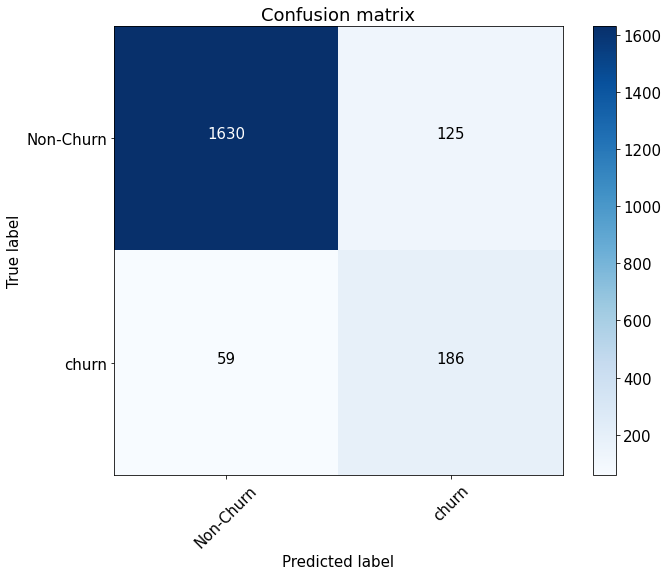

In [35]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [36]:
roc_auc_score(y_test, preds)

0.9472062329205186

In [37]:
#В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

###  mean, median, max 

In [37]:
def make_model_predict(method):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, method=method), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    
    target = pd.read_csv("Lection2/users_churn.csv")
    #target.head(3)
    
    X = pd.merge(user_embeddings, target, 'left')
    #X.head(3)
    
    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                        X['churn'], random_state=0)
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    #наши прогнозы для тестовой выборки
    preds = logreg.predict_proba(X_test)[:, 1]
    #preds[:10]
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    return method, thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)    

In [38]:
pd.DataFrame([
    make_model_predict(method='mean'),
    make_model_predict(method='median'),
    make_model_predict(method='max')
],
columns=['method', 'BestThreshold', 'FScore', 'Precision', 'Recall', 'roc_auc_score'])

,method,BestThreshold,FScore,Precision,Recall,roc_auc_score
0,mean,0.247834,0.671454,0.599359,0.763265,0.947206
1,median,0.322242,0.783838,0.776000,0.791837,0.971322
2,max,0.354191,0.788000,0.772549,0.804082,0.973485
